# How to Ultracell & Featurize

This notebook takes you through the steps done behind the scenes to compute design matrices in the other notebooks. After setting up the collection of crystals and rattling them / parsing MD trajectories or DFT simulations each structure is analyzed searching for nearest neighbors. This information is then used to compute design matrices which are made up of chunks corresponding to different feature types. Generating design matrices is actually a lot like sticking pieces of lego together.

An example of a __feature__ for an atom would be it's number of nearest neighbours within some cut-off distance. Towards the end will be quite a range of features shown one can use. Sticking with `sklearn`'s style all classes computing features have the same interface.

__Ultracells__ are supersets of supercells, making use of periodic boundary conditions. Ultracells are required for neighborhood searches in periodic boundary conditions. Features are numerical components that can be associated with individual atoms, allowing individual classification.

In [1]:
%matplotlib notebook
import numpy as np
from scipy import interpolate, spatial, special, misc
import itertools, warnings

import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model, utils, preprocessing
import sklearn
import atomtoolbox as atb

from ase.spacegroup import crystal
from ase import Atoms, io
from ase.lattice.cubic import FaceCenteredCubic, SimpleCubicFactory

import sys, os
from pottytrainer import parsers

E:\Programs\Anaconda3\envs\py35\lib\site-packages\ase\lattice\spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


## 1. Set up a crystal

### 1.1 Directly via ASE

In [2]:
size = (1,1,1)
a0 = 3.52
L12 = atb.L12Factory()
atoms = L12(directions=[[1,0,0],[0,1,0],[0,0,1]], size=size, 
                          symbol=["Al","Ni"],pbc=(1,1,1),latticeconstant=a0)

# a = 4.05
# atoms = crystal('Al', [(0,0,0)], spacegroup=225, cellpar=[a, a, a, 90, 90, 90],
#                      size=size)
print(atoms,atoms.get_chemical_symbols(),atoms.get_positions())

Lattice(symbols='AlNi3', pbc=True, cell=[3.52, 3.52, 3.52]) ['Al', 'Ni', 'Ni', 'Ni'] [[ 0.    0.    0.  ]
 [ 0.    1.76  1.76]
 [ 1.76  0.    1.76]
 [ 1.76  1.76  0.  ]]


### 1.2 Indirectly via parsing DFT files

In [2]:
dft_path = "E:/PetProjects/Empirical Potentials/castep/alloy_regression/Al-Ni/"

print("\nparsing DFT files...")
gip = parsers.general.GeneralInputParser(verbose=False)
gip.parse_all(dft_path)
gip.sort()
print("done")


parsing DFT files...
done


In [3]:
print(", ".join(["{}: {}".format(v,g.name) for v,g in enumerate(gip)]))

g = gip[54]
print(g.name)
fpos = g.get_positions(wrap=True)
species = g.get_species()
cell = g.get_cell()

atoms = Atoms(symbols=species, scaled_positions=fpos, 
              cell=cell, pbc=True)

print(atoms,atoms.get_chemical_symbols(),atoms.get_positions())

0: A1_a_0, 1: A1_a_1, 2: A1_a_10, 3: A1_a_11, 4: A1_a_12, 5: A1_a_13, 6: A1_a_14, 7: A1_a_15, 8: A1_a_16, 9: A1_a_2, 10: A1_a_3, 11: A1_a_4, 12: A1_a_5, 13: A1_a_6, 14: A1_a_7, 15: A1_a_8, 16: A1_a_9, 17: A2_a_0, 18: A2_a_1, 19: A2_a_10, 20: A2_a_11, 21: A2_a_12, 22: A2_a_13, 23: A2_a_14, 24: A2_a_15, 25: A2_a_16, 26: A2_a_2, 27: A2_a_3, 28: A2_a_4, 29: A2_a_5, 30: A2_a_6, 31: A2_a_7, 32: A2_a_8, 33: A2_a_9, 34: A3_a_0, 35: A3_a_1, 36: A3_a_10, 37: A3_a_11, 38: A3_a_12, 39: A3_a_13, 40: A3_a_14, 41: A3_a_15, 42: A3_a_16, 43: A3_a_2, 44: A3_a_3, 45: A3_a_4, 46: A3_a_5, 47: A3_a_6, 48: A3_a_7, 49: A3_a_8, 50: A3_a_9, 51: AlNi_ICSD_107713_a_0, 52: AlNi_ICSD_107713_a_1, 53: AlNi_ICSD_107713_a_10, 54: AlNi_ICSD_107713_a_11, 55: AlNi_ICSD_107713_a_12, 56: AlNi_ICSD_107713_a_13, 57: AlNi_ICSD_107713_a_14, 58: AlNi_ICSD_107713_a_15, 59: AlNi_ICSD_107713_a_16, 60: AlNi_ICSD_107713_a_2, 61: AlNi_ICSD_107713_a_3, 62: AlNi_ICSD_107713_a_4, 63: AlNi_ICSD_107713_a_5, 64: AlNi_ICSD_107713_a_6, 65: Al

### 1.3 Indirectly via a CIF File

In [2]:
path = r"E:\PetProjects\AtomToolBox\aflowlib_crystals\manual\ICSD_608800.cif"

if os.name != "posix":
    path = path.replace("\\","/")

atoms = io.read(path)
print(atoms)

Atoms(symbols='Al4Ni12', pbc=True, cell=[5.6016068159, 5.6016068159, 5.6016068159])


## 2. Get the Ultracell

The *Ultracell* is generated from replicating the supercell in various directions such that all periodic neighbours are captured.

<IPython.core.display.Javascript object>


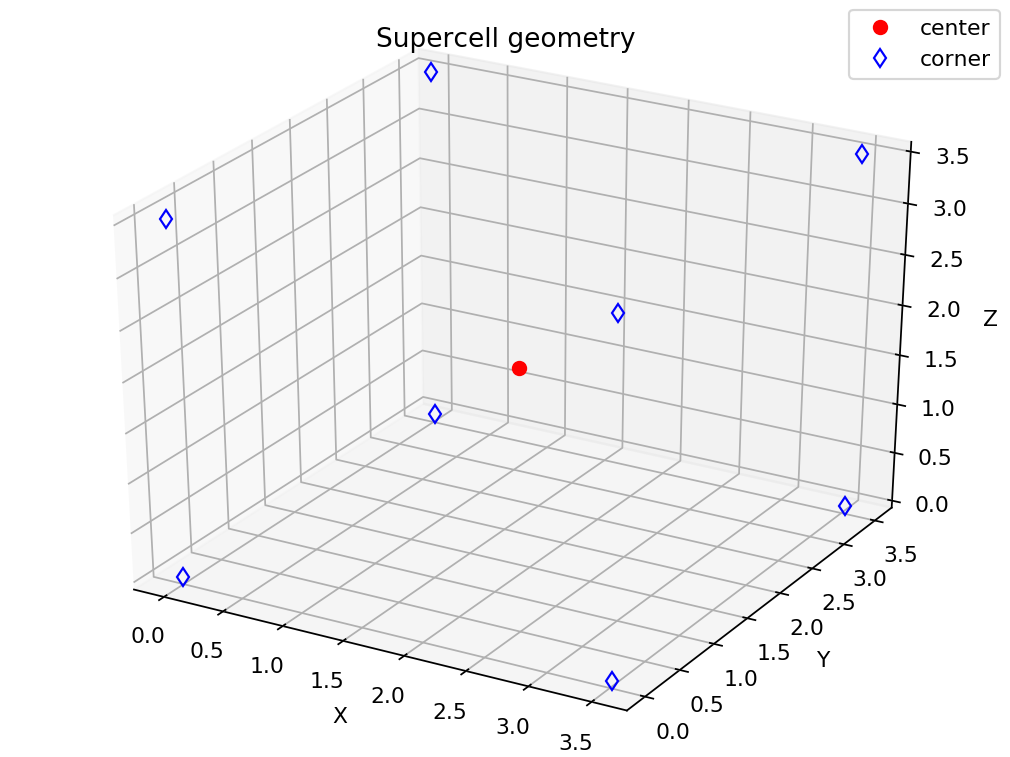

<IPython.core.display.Javascript object>


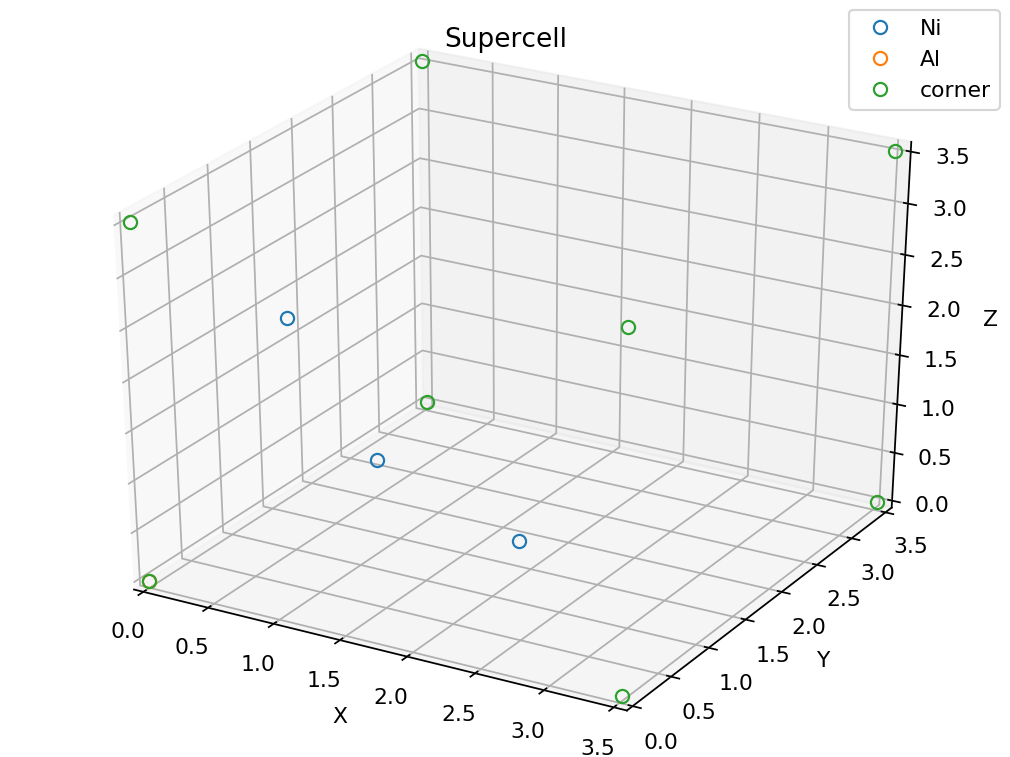

<IPython.core.display.Javascript object>


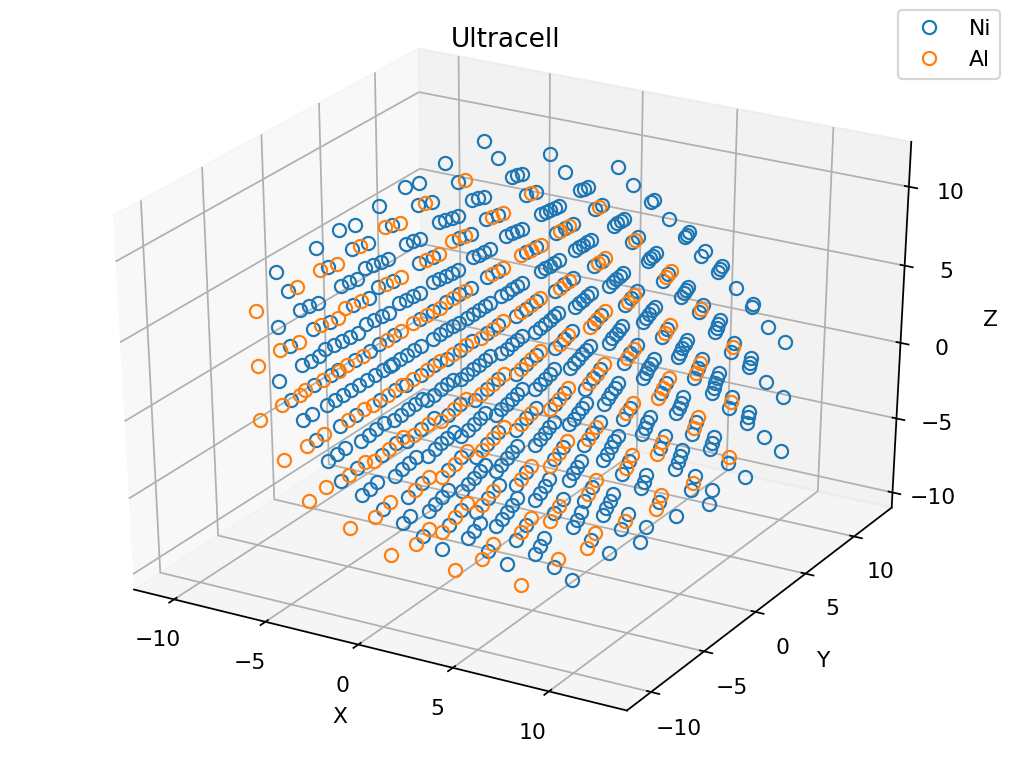

In [3]:
r_cut = 5.
positions = atoms.get_positions(wrap=True)
species = atoms.get_chemical_symbols()
upositions, uspecies, uindices = atb.get_ultracell(atoms=atoms, fpos=None, cell=None,
                                                   species=None,r_cut=r_cut,show=True,
                                                   verbose=False, max_iter=20, ftol=1e-6)

## 3. Calculate Neighbors

In [4]:
# getting the ultracell neighboring indices
uindices_neigh = atb.get_neighbors(positions,upositions=upositions, r_cut=r_cut, 
                          num_neigh=None)

### 3.1 Showing Neighbour Distance Distributions

<IPython.core.display.Javascript object>


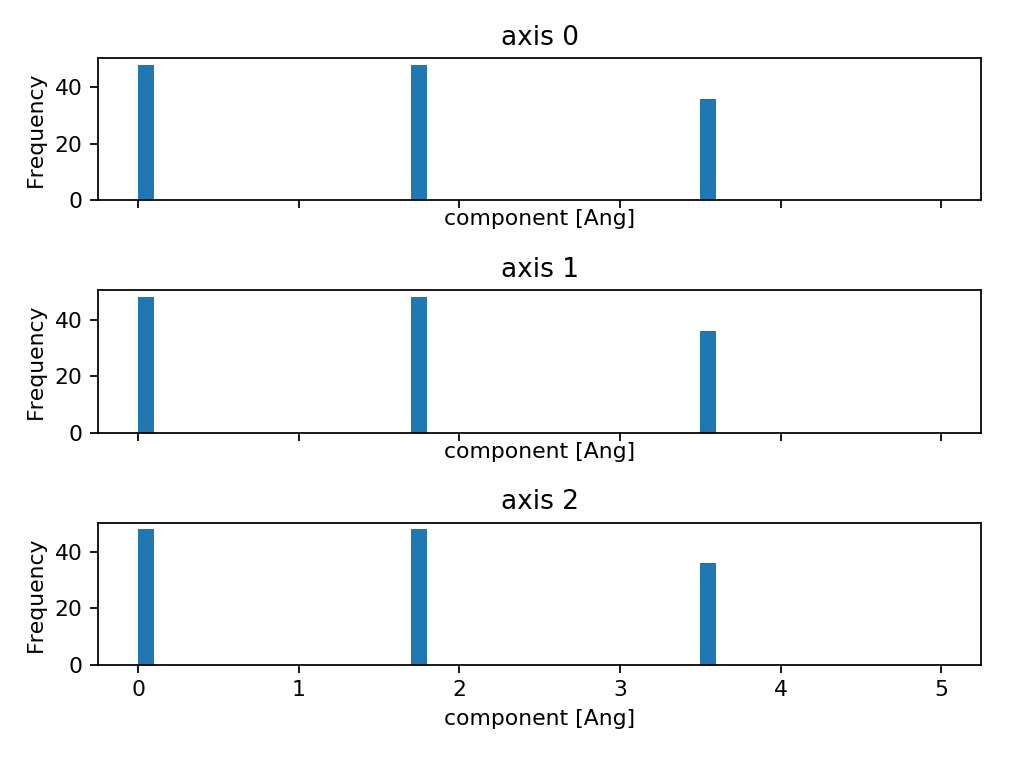

<IPython.core.display.Javascript object>


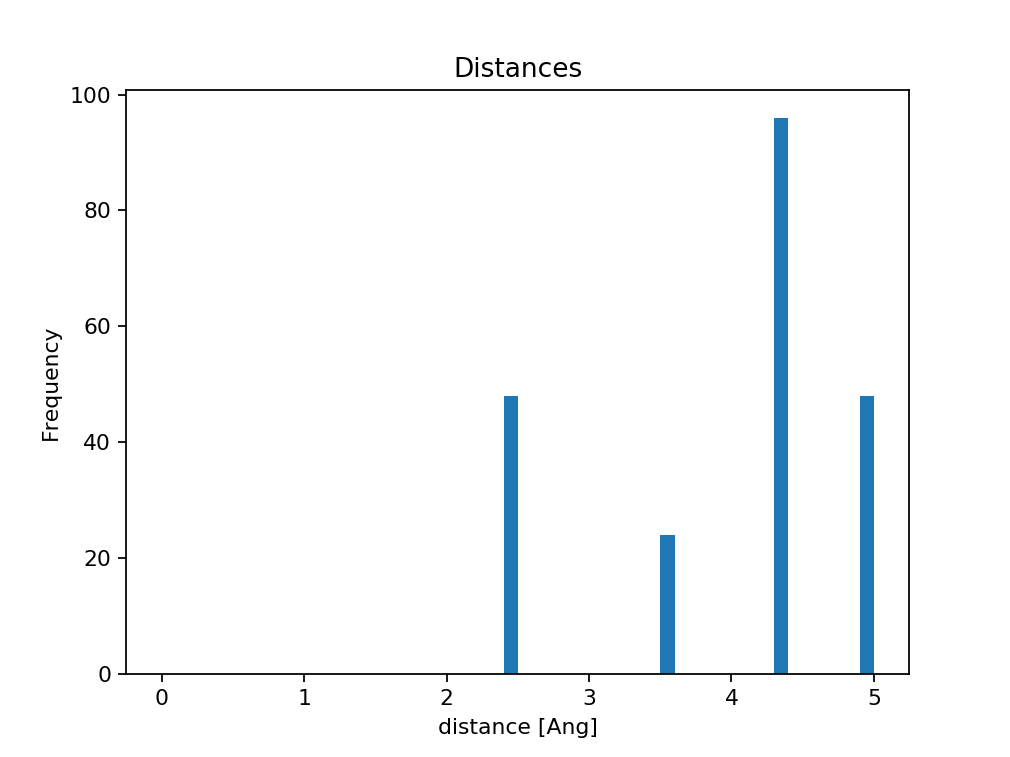

In [5]:
distance_vectors = [upositions[v] - positions[i] for i,v in enumerate(uindices_neigh)]

## component size distributions
f, axarr = plt.subplots(3, 1, sharex=True)
ylim = [0,0]
for i in range(3):
    tmp = np.hstack([d[:,i] for d in distance_vectors])
    axarr[i].hist(tmp, bins=50, range=(0,r_cut), label=str(i))
    axarr[i].set_title("axis "+str(i))
    axarr[i].set_xlabel("component [Ang]")
    axarr[i].set_ylabel("Frequency")
    _ylim = axarr[i].get_ylim()
    if _ylim[1]>ylim[1]:
        ylim[1] = _ylim[1]
for i in range(3):
    axarr[i].set_ylim(ylim)
    
plt.tight_layout()
plt.show()

# distance distribution
fig = plt.figure()
ax = fig.add_subplot(111)
tmp = np.hstack([np.linalg.norm(d,axis=1) for d in distance_vectors])
ax.hist(tmp, bins=50, range=(0,r_cut))
ax.set_xlabel("distance [Ang]")
ax.set_ylabel("Frequency")
ax.set_title("Distances")
plt.show()

### 3.2 Comparison of neighbor distance distributions implemented in AtomToolBox and ase.

<IPython.core.display.Javascript object>


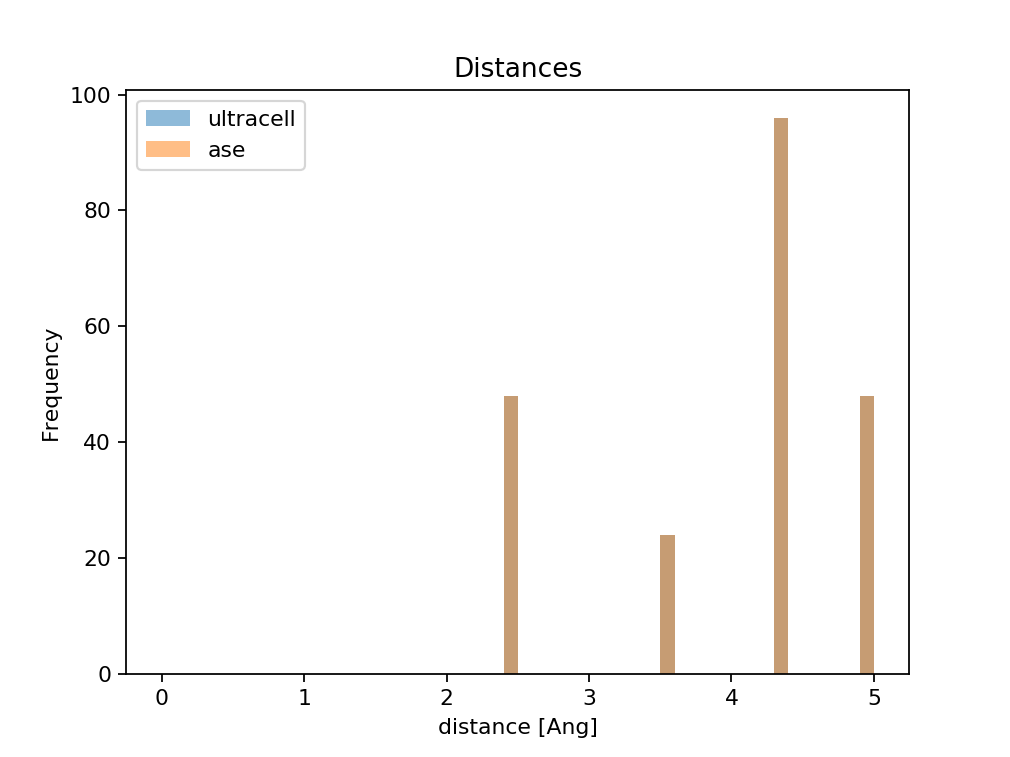

In [6]:
from ase import neighborlist

cell = atoms.get_cell()
nl = neighborlist.NeighborList([r_cut for v in range(atoms.positions.shape[0])],
                               bothways=True, self_interaction=False)
nl.update(atoms)
distance_vectors_ase = []
for i in range(atoms.positions.shape[0]):
    indices, offsets = nl.get_neighbors(i)
    pos = atoms.get_positions(wrap=True)
    distance_vectors_ase.append(pos[indices,:] + np.dot(offsets, cell) - pos[i,:])

# distance distribution comparison
fig = plt.figure()
ax = fig.add_subplot(111)
tmp = np.hstack([np.linalg.norm(d,axis=1) for d in distance_vectors])
ax.hist(tmp, bins=50, range=(0,r_cut), label="ultracell", alpha=.5)
tmp = np.hstack([np.linalg.norm(d,axis=1) for d in distance_vectors_ase])
r_valid = tmp < r_cut
ax.hist(tmp[r_valid], bins=50, range=(0,r_cut), label="ase", alpha=.5)
ax.set_xlabel("distance [Ang]")
ax.set_ylabel("Frequency")
ax.set_title("Distances")
plt.legend(loc=0)
plt.show()

## 4. Computing features

### 4.1 Three-body angle

XP  (4, 20)  XP_f  (20, 12)
XP  (4, 20)  XP_f  (20, 12)
XP  (4, 20)  XP_f  (20, 12)


<IPython.core.display.Javascript object>


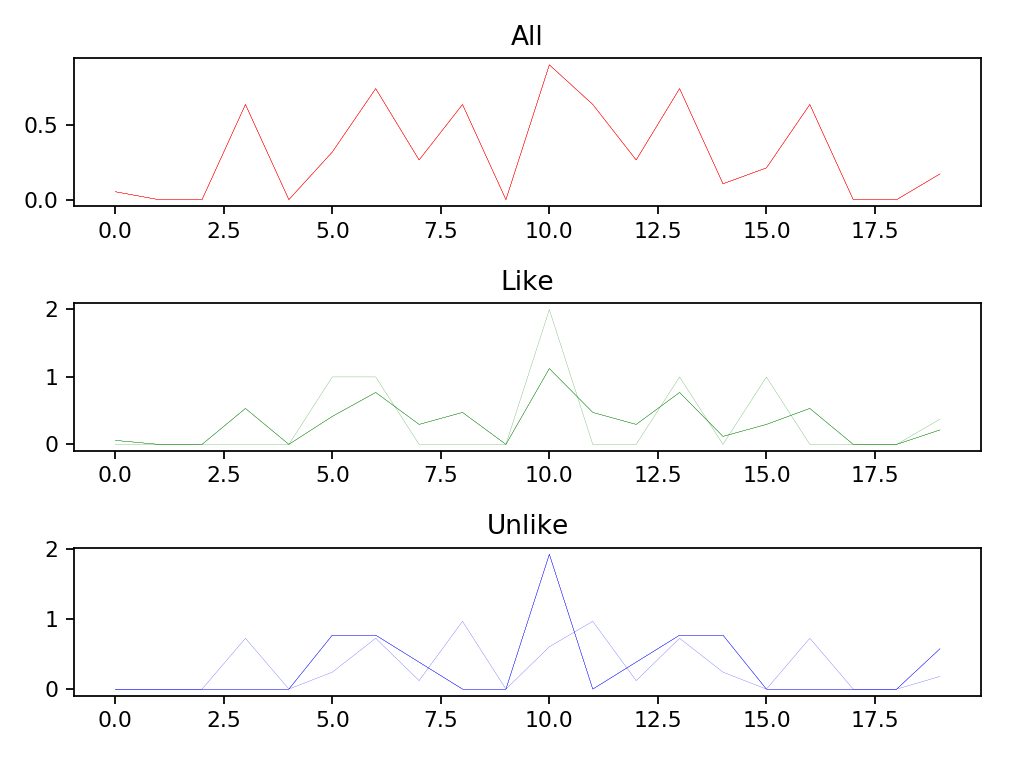

<IPython.core.display.Javascript object>


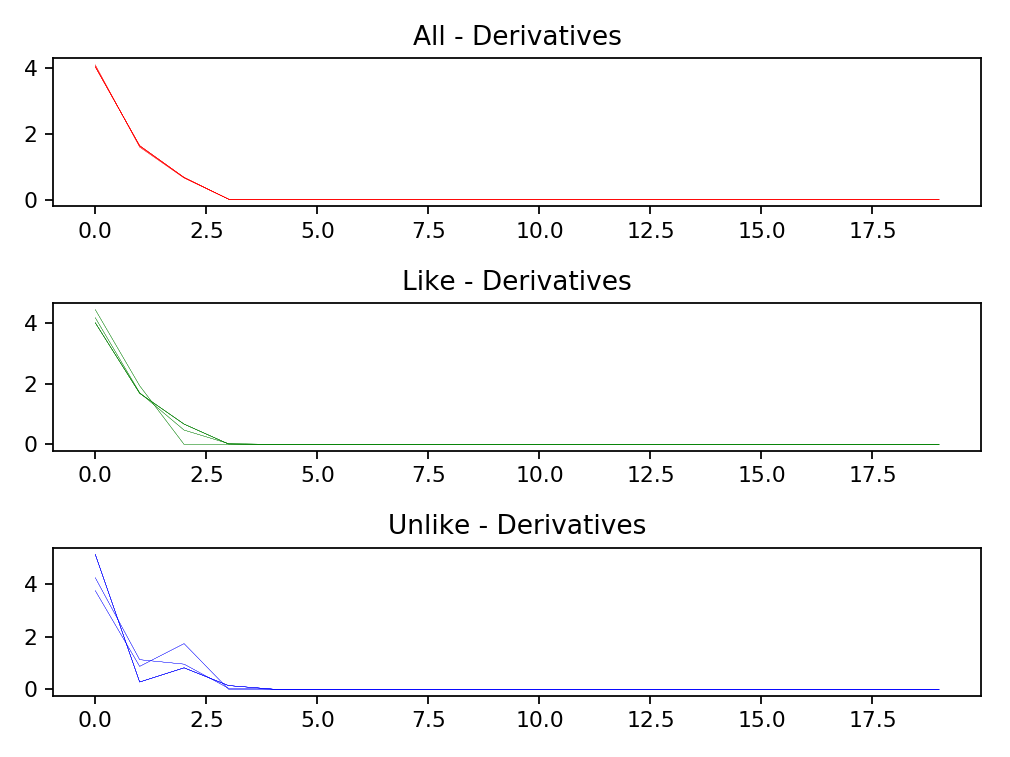

In [7]:
all_filter = lambda s,s_ref: np.array([True for v in range(s.shape[0])])
like_filter = lambda s,s_ref: s == s_ref
unlike_filter = lambda s,s_ref: s != s_ref

TBAF_all = atb.ThreeBodyAngleFeatures(k=20, _range=(0,np.pi), normed=True, 
                                  element_filter=all_filter, return_force=True)
Phi_all, Phi_all_der = TBAF_all.fit_transform(positions, species, upositions, uspecies, 
                                 uindices_neigh)

TBAF_like = atb.ThreeBodyAngleFeatures(k=20, _range=(0,np.pi), normed=True, 
                                   element_filter=like_filter, return_force=True)
Phi_like, Phi_like_der = TBAF_like.fit_transform(positions, species, upositions, uspecies, 
                                   uindices_neigh)

TBAF_unlike = atb.ThreeBodyAngleFeatures(k=20, _range=(0,np.pi), normed=True, 
                                     element_filter=unlike_filter, return_force=True)
Phi_unlike, Phi_unlike_der = TBAF_unlike.fit_transform(positions, species, upositions, uspecies, 
                                       uindices_neigh)

fig = plt.figure()
ax = fig.add_subplot(311)
for phi in Phi_all:
    ax.plot(phi,'r-',linewidth=.1)
ax.set_title("All")
    
ax1 = fig.add_subplot(312)
for phi in Phi_like:
    ax1.plot(phi,'g-',linewidth=.1)
ax1.set_title("Like")
    
ax2 = fig.add_subplot(313)
for phi in Phi_unlike:
    ax2.plot(phi,'b-',linewidth=.1)
ax2.set_title("Unlike")
plt.tight_layout()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(311)
for phi in Phi_all_der:
    ax.plot(phi,'r-',linewidth=.1)
ax.set_title("All - Derivatives")
    
ax1 = fig.add_subplot(312)
for phi in Phi_like_der:
    ax1.plot(phi,'g-',linewidth=.1)
ax1.set_title("Like - Derivatives")
    
ax2 = fig.add_subplot(313)
for phi in Phi_unlike_der:
    ax2.plot(phi,'b-',linewidth=.1)
ax2.set_title("Unlike - Derivatives")
plt.tight_layout()
plt.show()

### 4.3 Bond Order

<IPython.core.display.Javascript object>


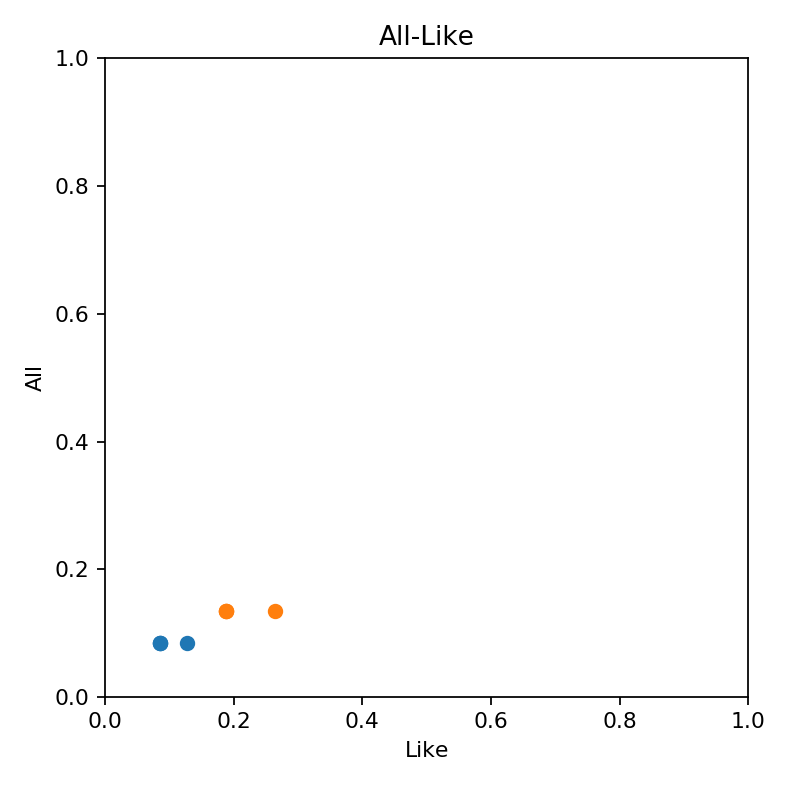

<IPython.core.display.Javascript object>


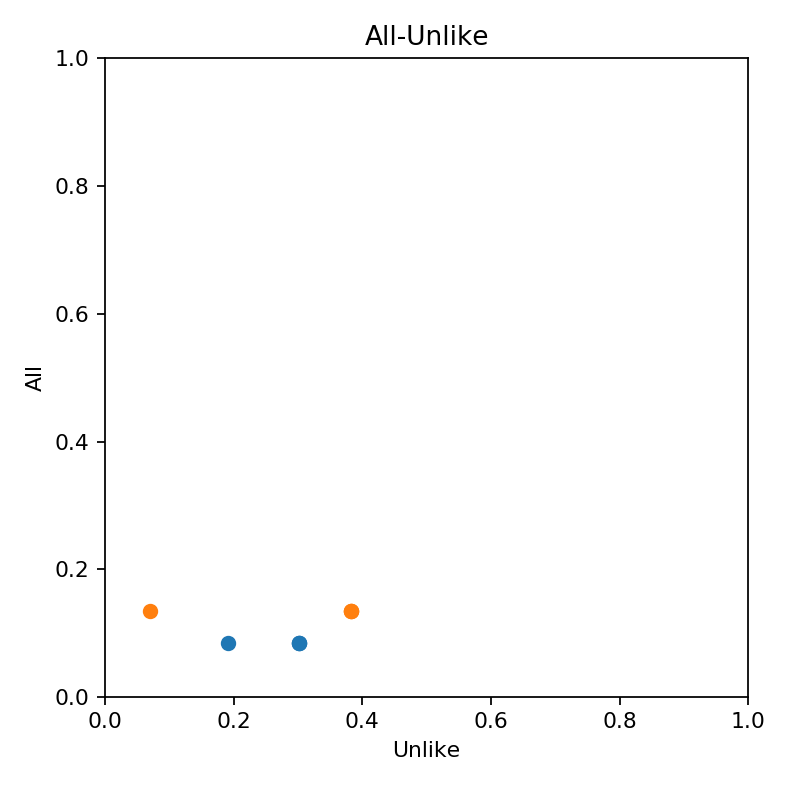

<IPython.core.display.Javascript object>


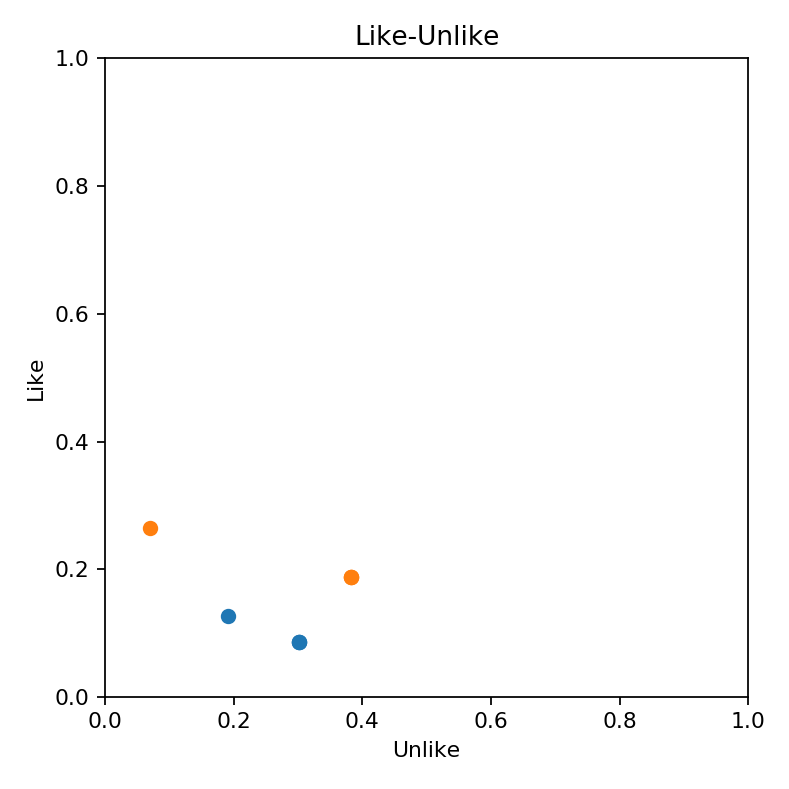

In [11]:
all_filter = lambda s,s_ref: np.array([True for v in range(s.shape[0])])
like_filter = lambda s,s_ref: s == s_ref
unlike_filter = lambda s,s_ref: s != s_ref

BOPF_all = atb.BondOrderParameterFeatures(k=[4,6], element_filter=all_filter)
Phi_all = BOPF_all.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

BOPF_like = atb.BondOrderParameterFeatures(k=[4,6], element_filter=like_filter)
Phi_like = BOPF_like.fit_transform(positions, species, upositions, uspecies, 
                                   uindices_neigh)

BOPF_unlike = atb.BondOrderParameterFeatures(k=[4,6], element_filter=unlike_filter)
Phi_unlike = BOPF_unlike.fit_transform(positions, species, upositions, uspecies, 
                                       uindices_neigh)

def show_features(Phi_all, Phi_like, Phi_unlike, xlim=None, ylim=None, figsize=(5,5)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for i in range(Phi_all.shape[1]):
        ax.plot(Phi_like[:,i],Phi_all[:,i],'o',linewidth=.1)
    ax.set_title("All-Like")
    ax.set_xlabel("Like")
    ax.set_ylabel("All")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for i in range(Phi_all.shape[1]):
        ax.plot(Phi_unlike[:,i],Phi_all[:,i],'o',linewidth=.1)
    ax.set_title("All-Unlike")
    ax.set_xlabel("Unlike")
    ax.set_ylabel("All")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for i in range(Phi_all.shape[1]):
        ax.plot(Phi_unlike[:,i],Phi_like[:,i],'o',linewidth=.1)
    ax.set_title("Like-Unlike")
    ax.set_xlabel("Unlike")
    ax.set_ylabel("Like")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.tight_layout()
    plt.show()
    
show_features(Phi_all, Phi_like, Phi_unlike, xlim=(0,1), ylim=(0,1))

### 4.4 Distance Tapering

<IPython.core.display.Javascript object>


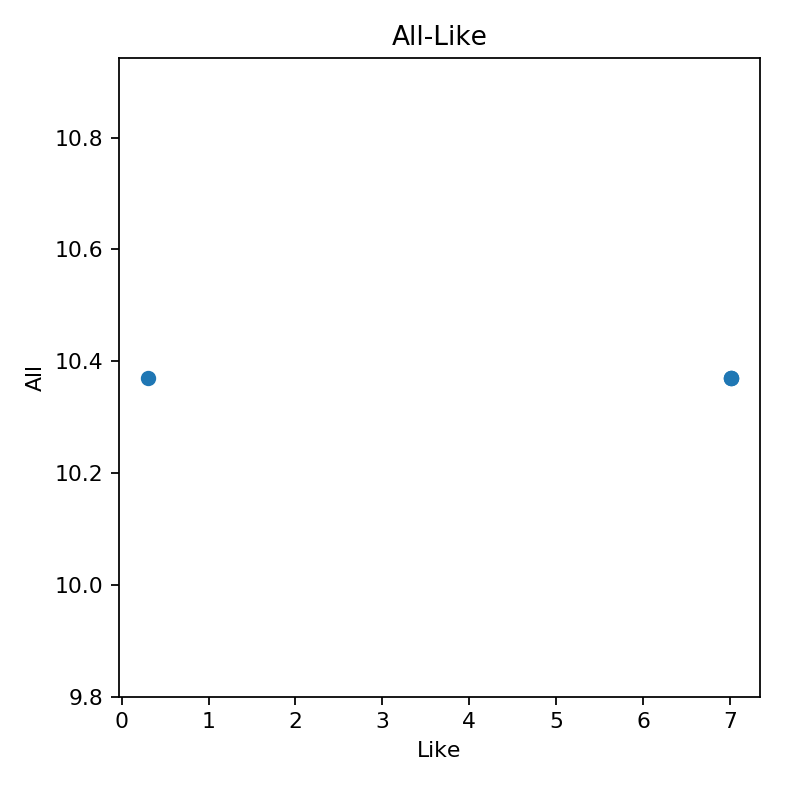

<IPython.core.display.Javascript object>


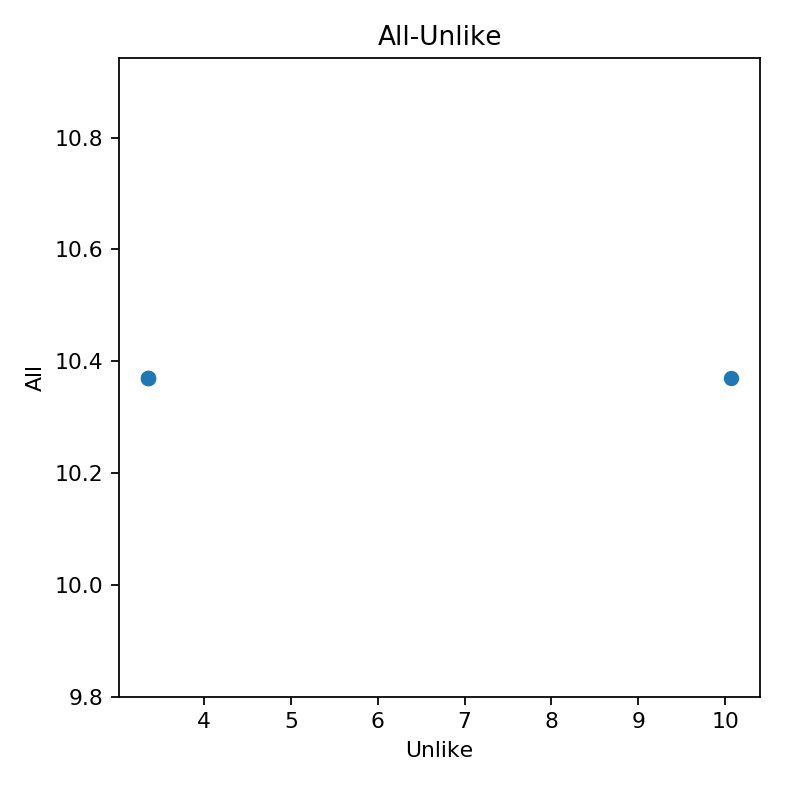

<IPython.core.display.Javascript object>


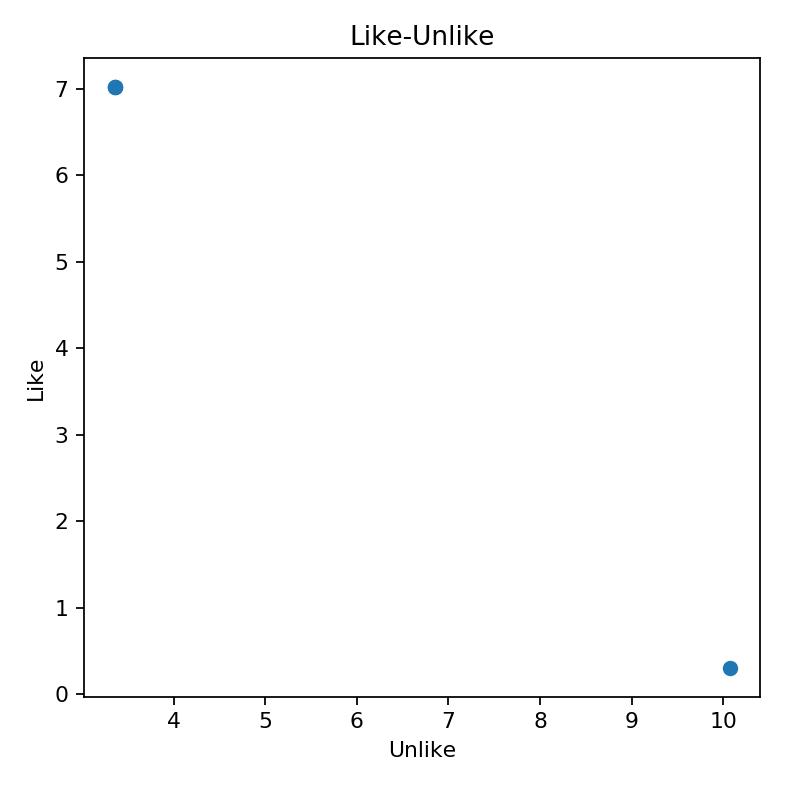

In [12]:
r_cut = 4.
DTF_all = atb.DistanceTaperingFeatures_2body(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=all_filter)
Phi_all = DTF_all.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

DTF_like = atb.DistanceTaperingFeatures_2body(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=like_filter)
Phi_like = DTF_like.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

DTF_unlike = atb.DistanceTaperingFeatures_2body(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=unlike_filter)
Phi_unlike = DTF_unlike.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

show_features(Phi_all, Phi_like, Phi_unlike, xlim=None, ylim=None)

Computing design matrix for derivatives.

In [14]:
DTF_all = atb.DistanceTaperingFeatures_2body(element_filter=all_filter, 
                                             taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             return_force=True)

Phi_all, Phi_f_all = DTF_all.fit_transform(positions, species, upositions, uspecies, 
                                           uindices_neigh)

print("final Phi_all ",Phi_all.shape, "Phi_f_all ",Phi_f_all.shape)

final Phi_all  (4, 1) Phi_f_all  (12, 1)


### 4.5 Distance Exponential Tapering

<IPython.core.display.Javascript object>


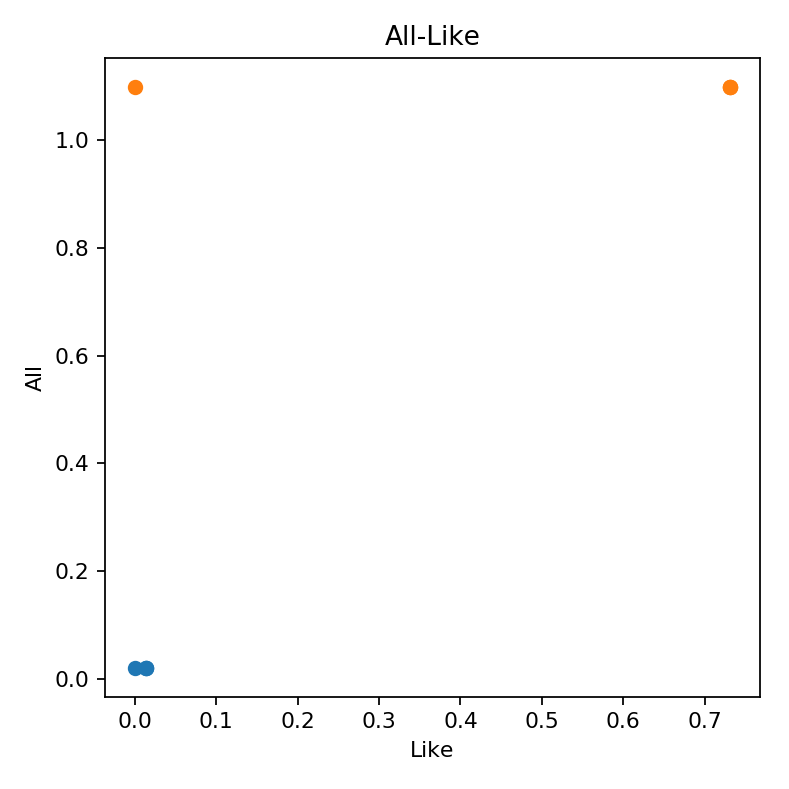

<IPython.core.display.Javascript object>


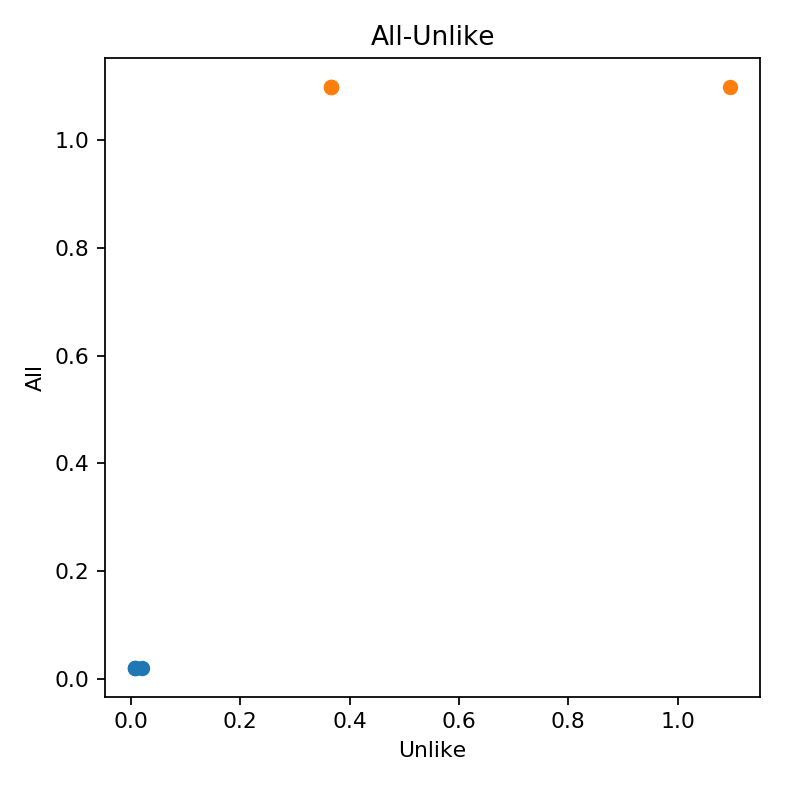

<IPython.core.display.Javascript object>


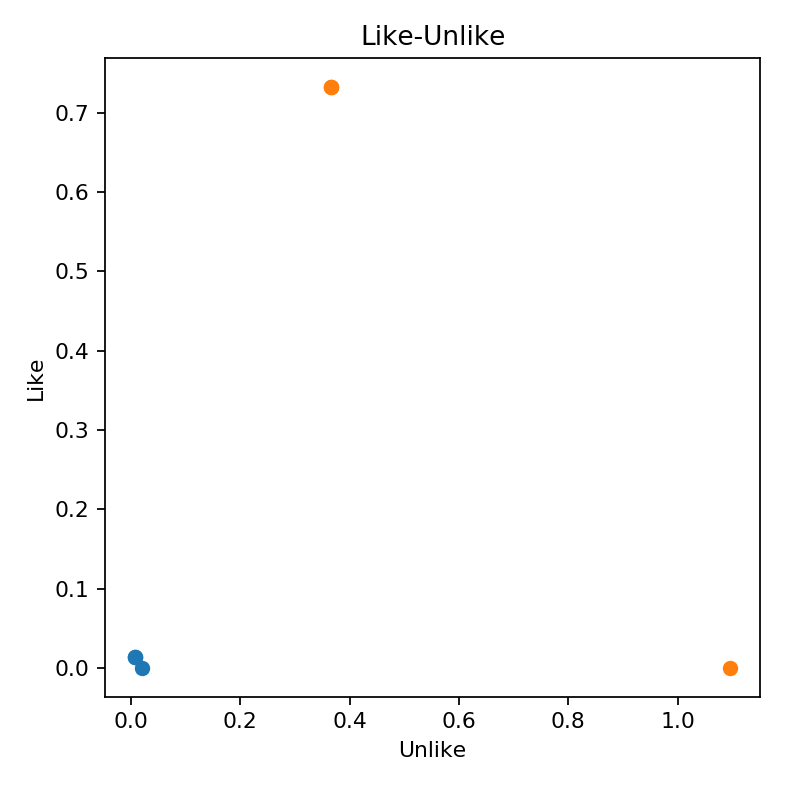

In [15]:
r_cut = 4.
DeTF_all = atb.DistanceExpTaperingFeatures_2body(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=all_filter, rs_=[0.,1.], eta_=[1.,1.])
Phi_all = DeTF_all.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

DeTF_like = atb.DistanceExpTaperingFeatures_2body(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=like_filter, rs_=[0.,1.], eta_=[1.,1.])
Phi_like = DeTF_like.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

DeTF_unlike = atb.DistanceExpTaperingFeatures_2body(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=unlike_filter, rs_=[0.,1.], eta_=[1.,1.])
Phi_unlike = DeTF_unlike.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

show_features(Phi_all, Phi_like, Phi_unlike, xlim=None, ylim=None)

Computing design matrix with derivatives.

In [16]:
DeTF_all = atb.DistanceExpTaperingFeatures_2body(element_filter=all_filter, 
                                            taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                            return_force=True, eta_=[1.,2.], rs_=[0,0])
Phi_all, Phi_f_all = DeTF_all.fit_transform(positions, species, upositions, uspecies, uindices_neigh)
print("final Phi_all ",Phi_all.shape, "Phi_f_all ",Phi_f_all.shape)

final Phi_all  (4, 2) Phi_f_all  (12, 2)


### 4.6 Distance Cosine Tapering

E:\Programs\Anaconda3\envs\py35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


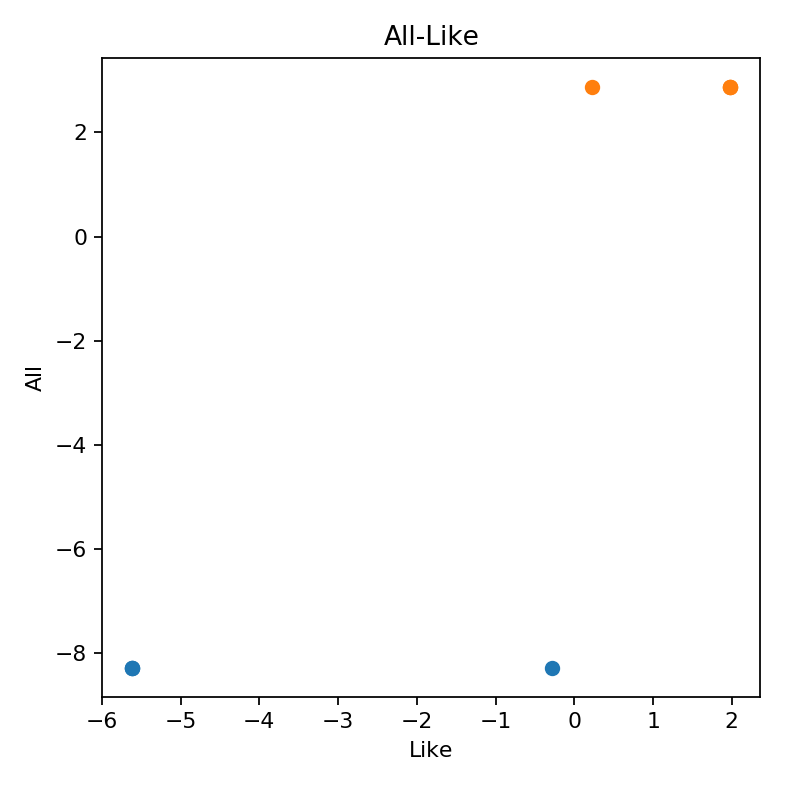

<IPython.core.display.Javascript object>


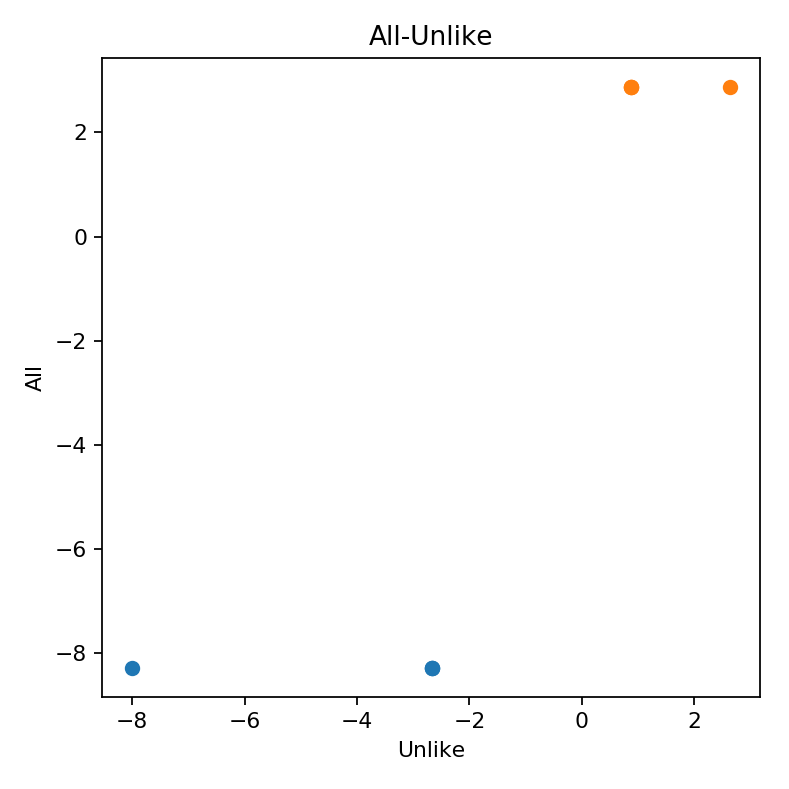

<IPython.core.display.Javascript object>


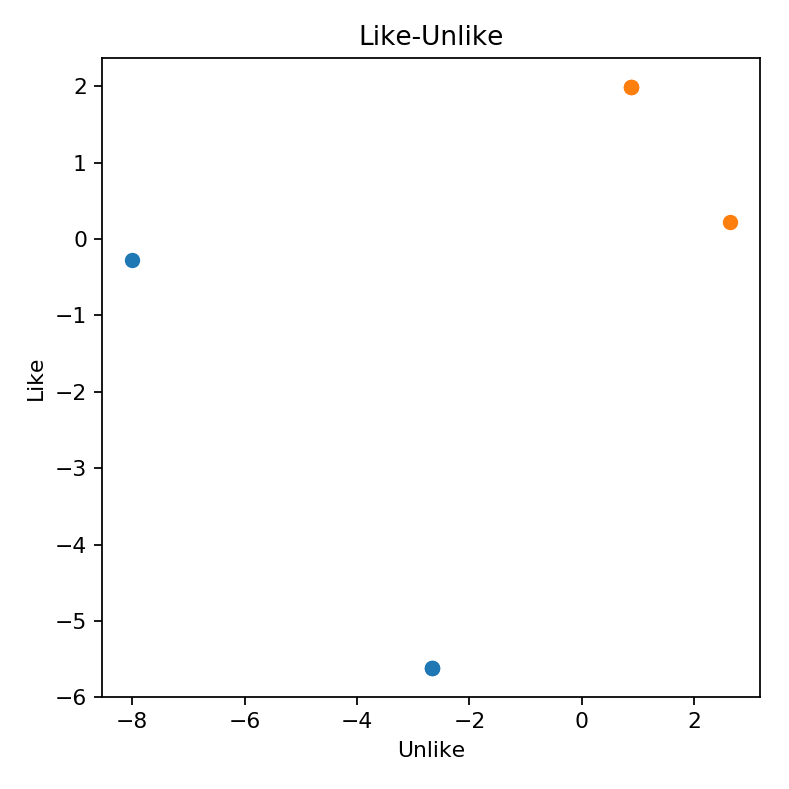

In [17]:
r_cut = 4.
DcTF_all = atb.DistanceCosTaperingFeatures_2body(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=all_filter, kappa_=[1.,2.])
Phi_all = DcTF_all.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

DcTF_like = atb.DistanceCosTaperingFeatures_2body(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=like_filter, kappa_=[1.,2.])
Phi_like = DcTF_like.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

DcTF_unlike = atb.DistanceCosTaperingFeatures_2body(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=unlike_filter, kappa_=[1.,2.])
Phi_unlike = DcTF_unlike.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

show_features(Phi_all, Phi_like, Phi_unlike, xlim=None, ylim=None)

In [18]:
DcTF_all = atb.DistanceCosTaperingFeatures_2body(element_filter=all_filter, 
                                            taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                            return_force=True, kappa_=[1.,2.])
Phi_all_, Phi_f_all = DcTF_all.fit_transform(positions, species, upositions, uspecies, uindices_neigh)
print("final Phi_all ",Phi_all.shape, "Phi_f_all ",Phi_f_all.shape)

final Phi_all  (4, 2) Phi_f_all  (12, 2)


### 4.7 Distance Cosine Exponential Tapering - 3body#1

E:\Programs\Anaconda3\envs\py35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


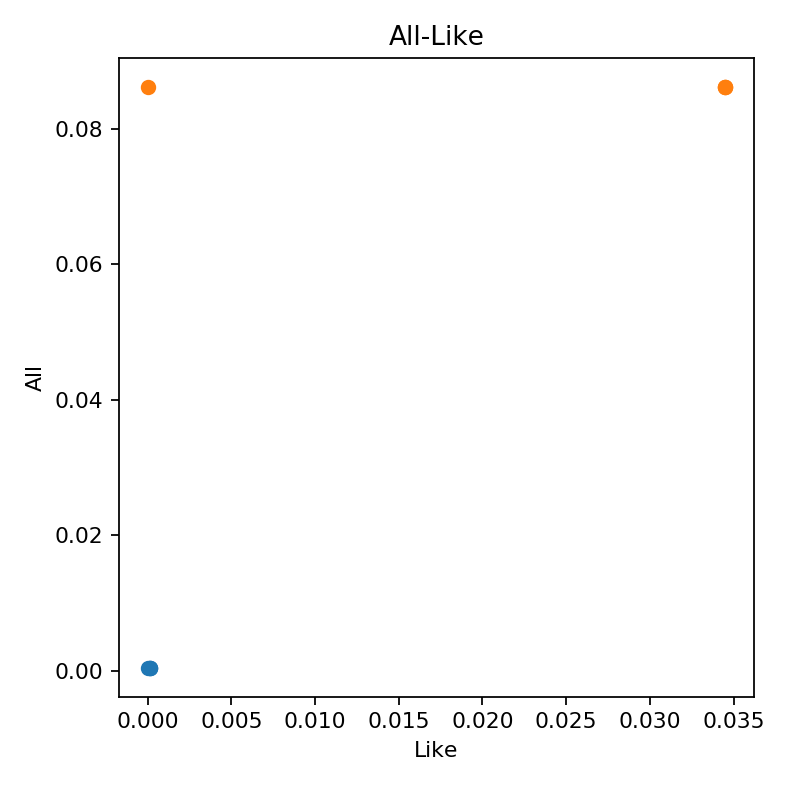

<IPython.core.display.Javascript object>


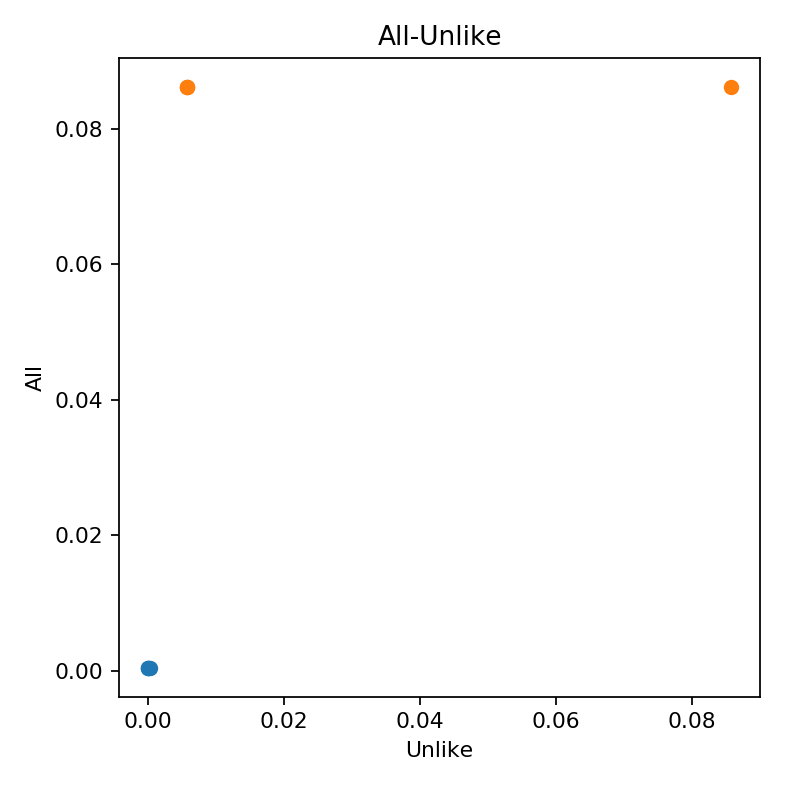

<IPython.core.display.Javascript object>


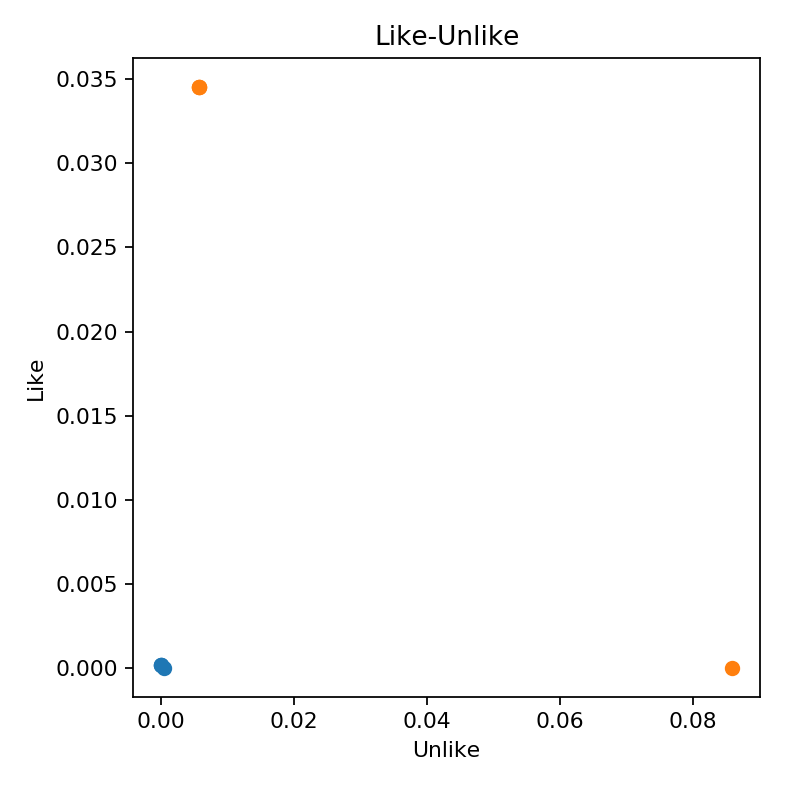

In [19]:
r_cut = 4.
DceTF_all = atb.DistanceCosExpTaperingFeatures_3body(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=all_filter, xi_=[0.,1.], lambda_=[1.,1.], eta_=[1.,.5])
Phi_all = DceTF_all.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

DceTF_like = atb.DistanceCosExpTaperingFeatures_3body(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=like_filter, xi_=[0.,1.], lambda_=[1.,1.], eta_=[1.,.5])
Phi_like = DceTF_like.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

DceTF_unlike = atb.DistanceCosExpTaperingFeatures_3body(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=unlike_filter, xi_=[0.,1.], lambda_=[1.,1.], eta_=[1.,.5])
Phi_unlike = DceTF_unlike.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

show_features(Phi_all, Phi_like, Phi_unlike, xlim=None, ylim=None)

Computing design matrix with derviatives.

In [20]:
all_filter = lambda s,s_ref: np.array([True for v in range(s.shape[0])])
taper_fun_params = dict(a=r_cut,b=1)
taper_fun = atb.taper_fun_wrapper(_type="x4le",**taper_fun_params)

DcTF3_all = atb.DistanceCosTaperingFeatures_3body(element_filter=all_filter,
                                        taper_fun=taper_fun, kappa_t=[0,1], kappa_r=[1,1],
                                             return_force=True)

Phi_all, Phi_all_der = DcTF3_all.fit_transform(positions, species, upositions, uspecies, 
                               uindices_neigh)
print(Phi_all.shape,Phi_all_der.shape)

XP  (4, 8)  XP_f  (8, 12)
(4, 8) (12, 8)


### 4.7 Distance Cosine Exponential Tapering - 3body#2

E:\Programs\Anaconda3\envs\py35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


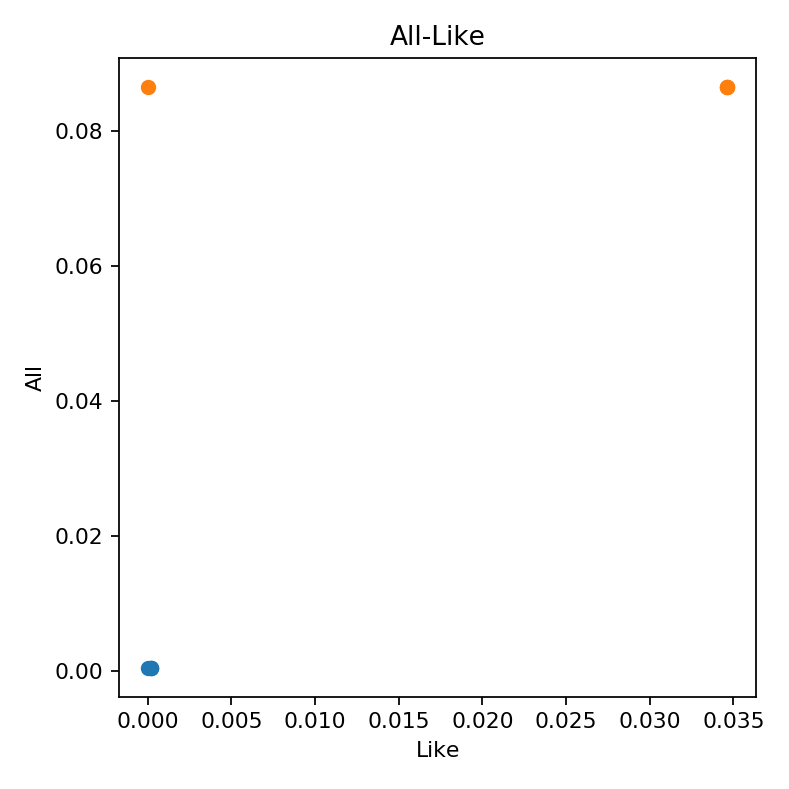

<IPython.core.display.Javascript object>


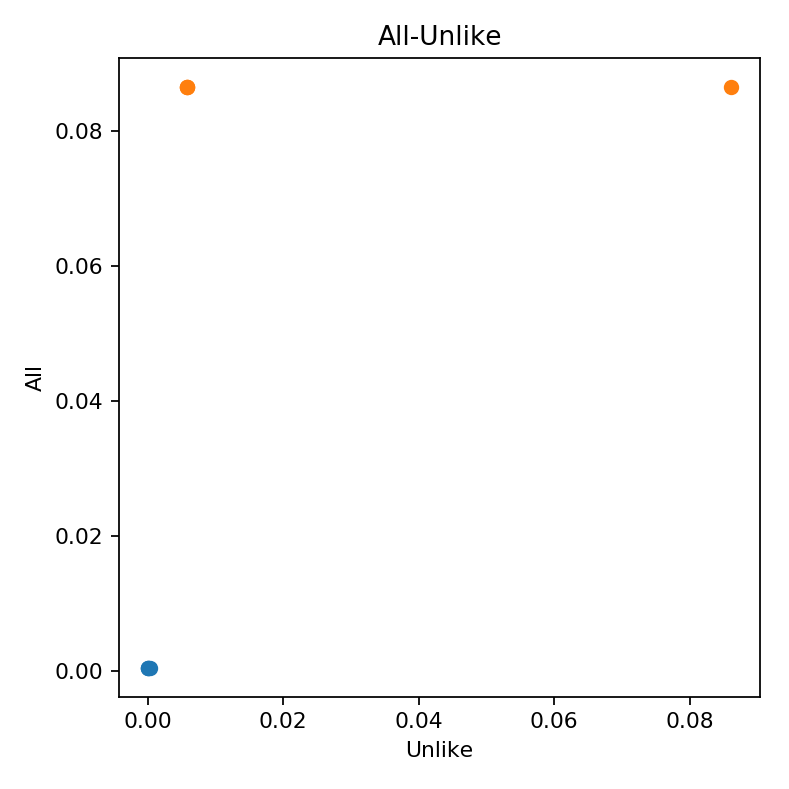

<IPython.core.display.Javascript object>


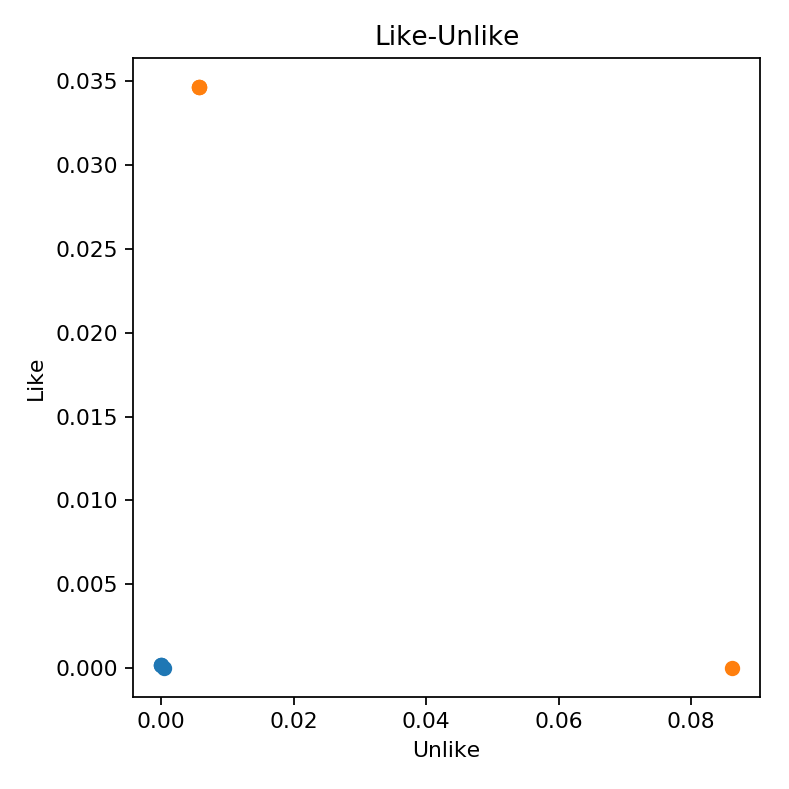

In [21]:
r_cut = 4.
DceTF_all = atb.DistanceCosExpTaperingFeatures_3body2(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=all_filter, xi_=[0.,1.], lambda_=[1.,1.], eta_=[1.,.5])
Phi_all = DceTF_all.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

DceTF_like = atb.DistanceCosExpTaperingFeatures_3body2(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=like_filter, xi_=[0.,1.], lambda_=[1.,1.], eta_=[1.,.5])
Phi_like = DceTF_like.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

DceTF_unlike = atb.DistanceCosExpTaperingFeatures_3body2(taper_fun=atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=1.),
                                             element_filter=unlike_filter, xi_=[0.,1.], lambda_=[1.,1.], eta_=[1.,.5])
Phi_unlike = DceTF_unlike.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

show_features(Phi_all, Phi_like, Phi_unlike, xlim=None, ylim=None)

### 4.8 Centro-Symmetry Parameter

E:\Programs\Anaconda3\envs\py35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


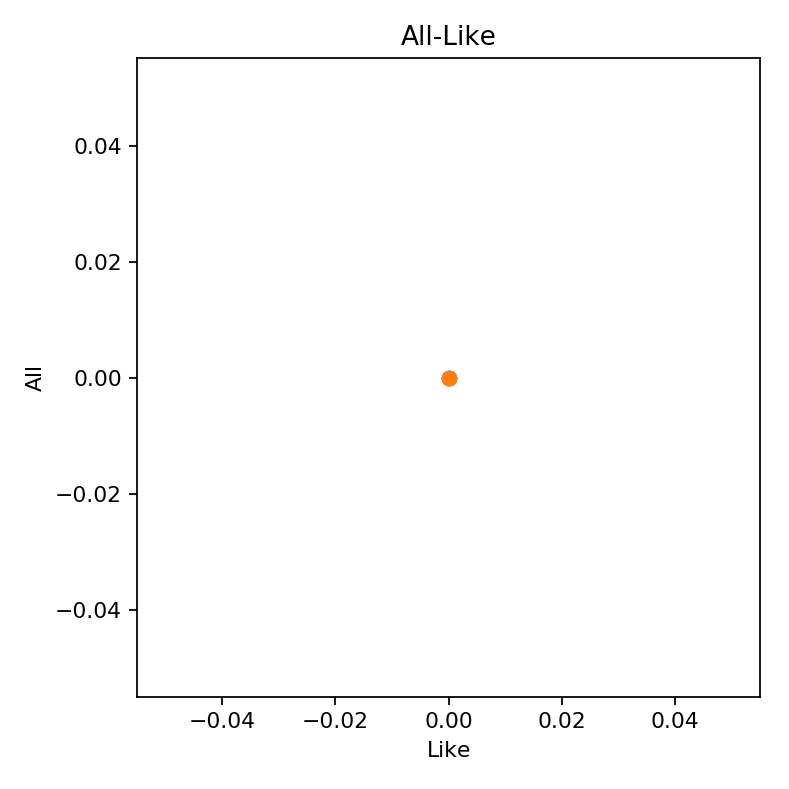

<IPython.core.display.Javascript object>


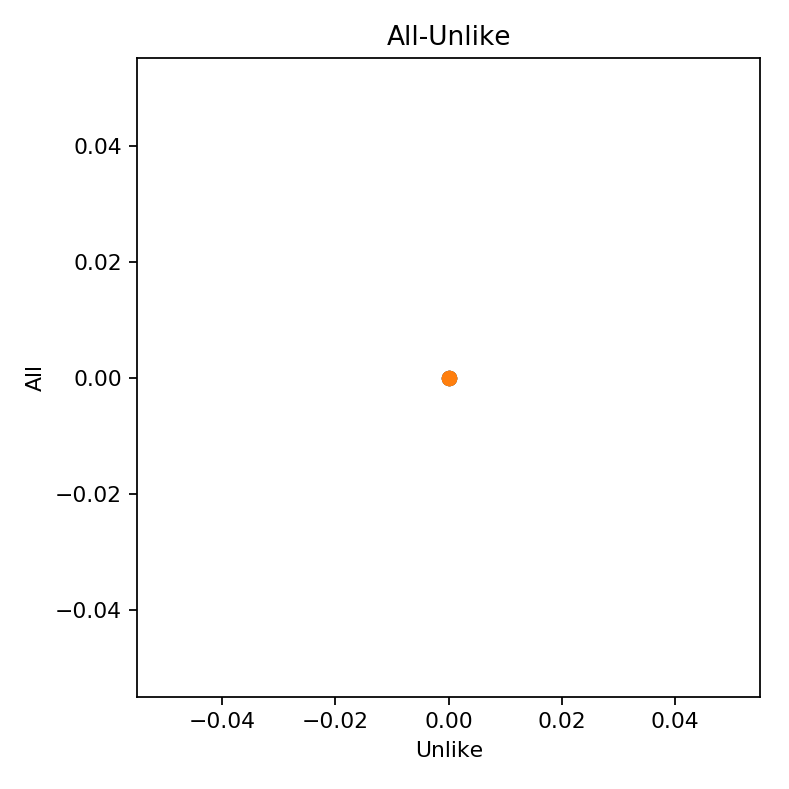

<IPython.core.display.Javascript object>


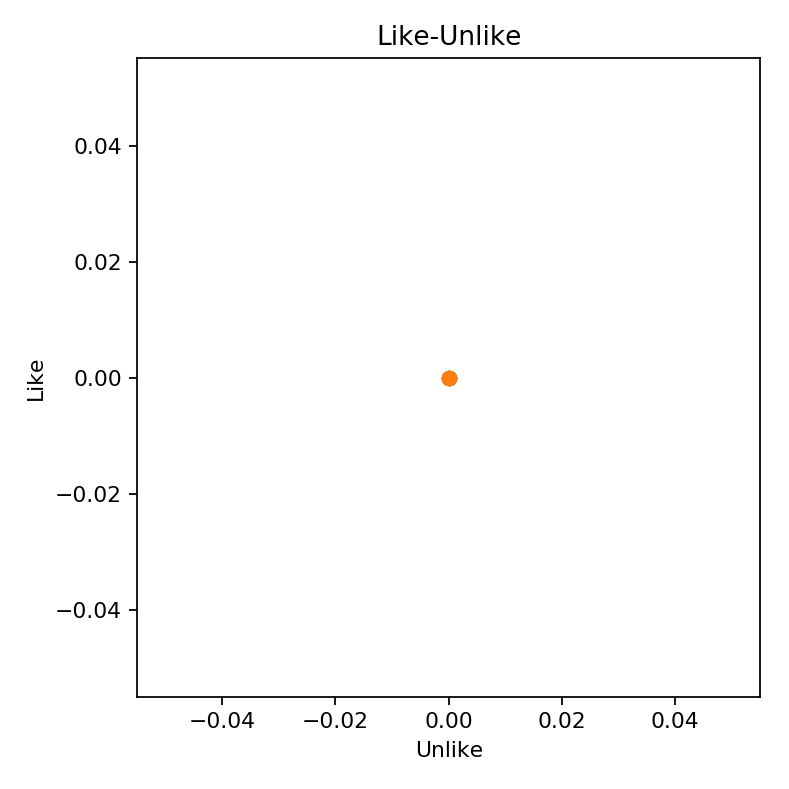

In [22]:
CSP_all = atb.CentroSymmetryParameterFeatures(N=[12,16],element_filter=all_filter)
Phi_all = CSP_all.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

CSP_like = atb.CentroSymmetryParameterFeatures(N=[12,16],element_filter=like_filter)
Phi_like = CSP_like.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

CSP_unlike = atb.CentroSymmetryParameterFeatures(N=[12,16],element_filter=unlike_filter)
Phi_unlike = CSP_like.fit_transform(positions, species, upositions, uspecies, uindices_neigh)

show_features(Phi_all, Phi_like, Phi_unlike, xlim=None, ylim=None)

### 4.9 Gaussian Based

In [23]:
all_filter = lambda s,s_ref: np.array([True for v in range(s.shape[0])])
taper_fun_params = dict(a=r_cut,b=1)
taper_fun = atb.taper_fun_wrapper(_type="x4le",**taper_fun_params)

q_ = np.linspace(0, r_cut, 50)
p_ = np.array([.1, .5, 1.])

DGTF_all = atb.DistanceGaussTaperingFeatures_2body(element_filter=all_filter,
                                        taper_fun=taper_fun, p_=p_, q_=q_,
                                             return_force=True)

Phi_all, Phi_all_der = DGTF_all.fit_transform(positions, species, upositions, uspecies, 
                               uindices_neigh)
print(Phi_all.shape,Phi_all_der.shape)
print(Phi_all,Phi_all_der)

(4, 150) (12, 150)
[[  5.15796858e-01   5.58688073e-01   6.04344386e-01   6.52865829e-01
    7.04348686e-01   7.58884661e-01   8.16560007e-01   8.77454636e-01
    9.41641190e-01   1.00918410e+00   1.08013865e+00   1.15454996e+00
    1.23245210e+00   1.31386710e+00   1.39880398e+00   1.48725794e+00
    1.57920939e+00   1.67462316e+00   1.77344777e+00   1.87561464e+00
    1.98103754e+00   2.08961197e+00   2.20121476e+00   2.31570368e+00
    2.43291721e+00   2.55267441e+00   2.67477494e+00   2.79899915e+00
    2.92510839e+00   3.05284541e+00   3.18193490e+00   3.31208421e+00
    3.44298422e+00   3.57431027e+00   3.70572341e+00   3.83687157e+00
    3.96739108e+00   4.09690814e+00   4.22504057e+00   4.35139954e+00
    4.47559146e+00   4.59722002e+00   4.71588814e+00   4.83120021e+00
    4.94276414e+00   5.05019364e+00   5.15311036e+00   5.25114614e+00
    5.34394520e+00   5.43116623e+00   4.43519911e-05   6.47405117e-05
    9.39427930e-05   1.35510561e-04   1.94313384e-04   2.76980572e-04
 

### 4.10 Sine+Cosine

In [24]:
all_filter = lambda s,s_ref: np.array([True for v in range(s.shape[0])])
taper_fun_params = dict(a=r_cut,b=1)
taper_fun = atb.taper_fun_wrapper(_type="x4le",**taper_fun_params)

DscTF_all = atb.DistanceSineCosineTaperingFeatures_2body(element_filter=all_filter,
                                        taper_fun=taper_fun, kappa_=[0,1.],
                                             return_force=True)

Phi_all, Phi_all_der = DscTF_all.fit_transform(positions, species, upositions, uspecies, 
                               uindices_neigh)
print(Phi_all.shape,Phi_all_der.shape)
print(Phi_all,Phi_all_der)

(4, 4) (12, 4)
[[ 5.95634441  1.41824595  0.         -5.73753815]
 [ 5.95634441  1.41824595  0.         -5.73753815]
 [ 5.95634441  1.41824595  0.         -5.73753815]
 [ 5.95634441  1.41824595  0.         -5.73753815]] [[  2.77555756e-17   3.12250226e-16   0.00000000e+00   4.16333634e-16]
 [  1.66533454e-16  -1.24900090e-16   0.00000000e+00   5.55111512e-17]
 [ -4.44089210e-16   8.32667268e-17   0.00000000e+00   0.00000000e+00]
 [ -1.94289029e-16   7.63278329e-17   0.00000000e+00   0.00000000e+00]
 [  1.16573418e-15   1.81799020e-15   0.00000000e+00  -1.05471187e-15]
 [  1.24900090e-15   1.64451786e-15   0.00000000e+00  -1.38777878e-15]
 [  1.16573418e-15   1.59594560e-15   0.00000000e+00  -1.27675648e-15]
 [  1.38777878e-16  -2.01227923e-16   0.00000000e+00  -1.11022302e-16]
 [  1.55431223e-15   1.88737914e-15   0.00000000e+00  -1.58206781e-15]
 [  1.22124533e-15   1.60982339e-15   0.00000000e+00  -1.02695630e-15]
 [  9.99200722e-16   1.72084569e-15   0.00000000e+00  -1.08246745e-15]

### 5. Computing A Mapper for the Basis Functions

In [25]:
elements = ["Al","Ni"]
pairs = [(elements[i], elements[j]) for i,j in \
         itertools.product(range(len(elements)), range(len(elements))) if i<=j]

# embedding density contribution filter
emb_filter = atb.element_emb_filters()

return_force = True
kappa_ = np.arange(0,50)/float(r_cut)
kappa_emb_ = None#np.arange(0,50)/float(1.)
kappa_t = None#np.arange(0,25) # three body expansion
kappa_r = None#np.arange(0,10)/float(r_cut)
q_ = np.linspace(0, r_cut, 50)
p_ = np.array([.1, .5, 1.])
taper_fun = atb.taper_fun_wrapper(_type="x4ge",a=r_cut,b=.05)
#taper_fun_emb = taper_fun_wrapper(_type="x4le",a=0,b=.05)
taper_fun_emb = atb.taper_fun_wrapper(_type="Ones")
emb_density_funs = {k: None for k in elements}

gauss_params = lambda p0,p1: {"element_filter":atb.element_pair_filters(el_ref=p0,el_neigh=p1,kind="symmetric"),\
                "p_":p_, "q_":q_, "taper_fun":taper_fun}
sc_params = lambda p0, p1: {"element_filter":atb.element_pair_filters(el_ref=p0,el_neigh=p1,kind="symmetric"),\
             "kappa_":kappa_, "taper_fun":taper_fun,"kappa_t":kappa_t,
             "kappa_r":kappa_r}

params_pair = {p0+p1: [gauss_params(p0,p1), sc_params(p0,p1)] for (p0,p1) in pairs}

sc_params_emb = {"element_filter":emb_filter, "kappa_":kappa_emb_, 
                 "taper_fun":taper_fun_emb, "emb_density_funs":{k:None for k in elements}}
gauss_params_emb = {"element_filter":emb_filter, "taper_fun":taper_fun_emb, "p_":p_, 
                    "q_":q_, "emb_density_funs":{k:None for k in elements}}

params_emb = {el: [sc_params_emb, gauss_params_emb] for el in elements}

features_class = [atb.DistanceGaussTaperingFeatures_2body,atb.DistanceSineCosineTaperingFeatures_2body] #atb.DistanceSineCosineTaperingFeatures_2body,atb.DistanceCosTaperingFeatures_2body,

mapper = atb.get_mapper(params_emb, params_pair, features_class, densgiven=False)
print("features_class",mapper["features_class"])
print("\npair",mapper["pair"])

features_class {'emb': {'Al': {}, 'Ni': {}}, 'pair': {'NiNi': {'DistanceGaussTaperingFeatures_2body': array([500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
       513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525,
       526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538,
       539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551,
       552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564,
       565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577,
       578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590,
       591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603,
       604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616,
       617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629,
       630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642,
       643, 644, 645, 646, 647, 648, 649]), 'DistanceSineCosineTaperingFeatures_2body': array([650, 651, 6